# Zero-shot image classification

In this notebook, we will use `textograph` to perform a zero-shot image classification experiment. We will build a classifier that can run predictions on a dataset on a set of labels provided at runtime, without any finetuning. In fact, multimodal image/texts models such as CLIP can map images and texts features into a shared latent space, thus enabling us to cast the classification problem into a nearest neighbour problem within the latent space, treating the labels as text. 

Rarely zero-shot models can match supervised models in terms of accuracy, but their properties can be very remarkable for some use-cases:
- Zero-shot models do not require labeled data, which is very costly
- Zero-shot models are resilient to data imbalancing issue by design. 
- Zero-shot models failure cases look like human-like errors
- Zero-shot models can be used as a starting point to build labeled dataset that can be used to train a proper supervised model, using a self-supervised-like paradigm (we used a separate model to self-label the data at no cost).

We will demonstrate these properties in this notebook. We will first train a basic baseline model on the Fashion Product dataset in a supervised fashion, then we will compare its accuracy with the zero-shot model. We will then perform some error analysis to get some insights about the two models. We will finally use the zero-shot predictions to build a dummy train dataset and retrain the baseline model on this dataset, to verify if the self-supervised approach can lead to the creation of a valid labeled dataset that can be used to train a reliable supervised classifier.

### Expected limitations

Zero-shot models will fail when they are fed with data whose label is not mapped in the predetermined set of labels (ex. input image is a parrot but my set of labels are "dog", "cat", "turtle"). This is not a huge disadvantage compared to supervised model, as they would fail too, but, in real-world scenarios, this would require a careful design of the possible label set to avoid black spots in the model possible predictions. This failure case is mitigated in supervised model by the assumption that the training dataset, with its labels, represents an informative sample of the use-case data distribution. In a zero-shot setting, this issue must be kept in check by monitoring how input data distributions drift over time and if there are some obvious failure cases by inspection. The good thing about zero-shot models is that they can be reconfigured very easily, editing a simple line of code.

Another issue to keep in mind is that, at the current moment, the image and text encoders semantic understanding and reasoning is still limited, thus the approach works best when the target space refers to easily detectable visual attributes of the image. Use-cases like fault detection (ex. detect products with defects) might not be easily manageable by a zero-shot model.

### Import libraries

We use Tensorflow==2.8.3 due to a bug on data augmentation layers that makes training much slower when used in 2.9 or 2.10. https://stackoverflow.com/questions/73770146/warningtensorflowusing-a-while-loop-for-converting-cause-there-is-no-registere

In [1]:
import sys
sys.path.append('..')
import os
import random
import torch
import numpy as np
import tensorflow as tf

print("TF version: ", tf.__version__)

from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset, Features, ClassLabel, DatasetDict, concatenate_datasets

#TF needed to train a supervised baseline
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from textograph.indexers import Index
from textograph.models.huggingface import CLIP_Model
from textograph.handlers import ZeroShotImageClassificationHandler
from textograph.utils import batch

seed = 42

random.seed(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 


TF version:  2.8.3


We load the Fashion Product dataset from HuggingFace. We take the first 5000 samples to ease the computations on low-end machines.

We will train the models to predict the garment category, mapped in the "subCategory" column.

In [2]:
full_dataset = load_dataset("ceyda/fashion-products-small", split='train')
dataset = full_dataset.select(range(5000)) #train is the only "official" split

Using custom data configuration ceyda--fashion-products-small-ad468eb94e8d93de
Found cached dataset parquet (C:/Users/user/.cache/huggingface/datasets/ceyda___parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [3]:
dataset_df_full = full_dataset.to_pandas()
dataset_df = dataset.to_pandas()
dataset_df.head()

,filename,link,id,masterCategory,gender,subCategory,image
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970,Apparel,Men,Topwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386,Apparel,Men,Bottomwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263,Accessories,Women,Watches,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379,Apparel,Men,Bottomwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759,Apparel,Men,Topwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


<AxesSubplot: >

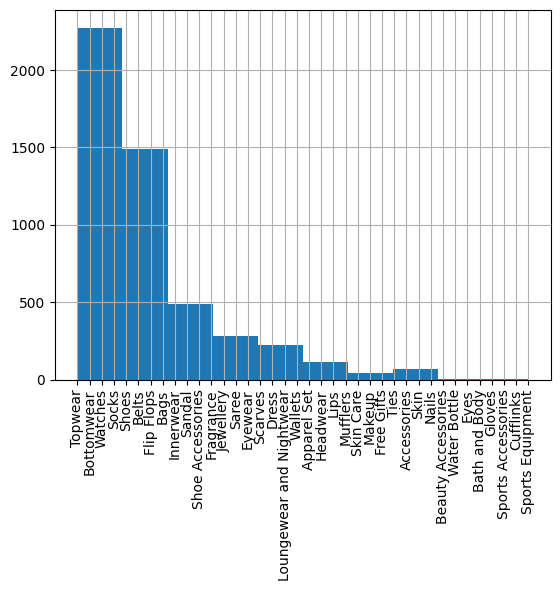

In [4]:
dataset_df.subCategory.hist(xrot=90)

In [5]:
dataset_df.subCategory.nunique()

38

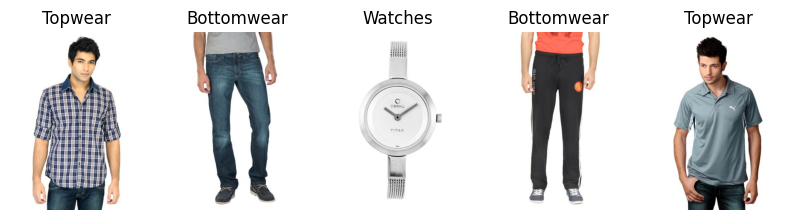

In [6]:
fig, ax = plt.subplots(1,5, figsize=(10,3))
for i in range(5):
    sample = dataset[i]
    ax[i].imshow(sample['image'])
    plt.axis='off'
    ax[i].set_title(sample['subCategory'])
    ax[i].axis('off')
plt.show()


We map the target column to a integer, to prepare the dataset for training. We also perform some other preprocessing operations

In [7]:
def process_hf_dataset(dataset):
    dataset = dataset.add_column('subCategory_cat', dataset['subCategory'])
    label_features = ClassLabel(names=dataset_df_full.subCategory.unique().tolist())
    new_features = dataset.features.copy()
    new_features['subCategory_cat'] = label_features
    dataset = dataset.cast(new_features)
    #Not all images have same resolutions, this might cause issues. This operation will take some time
    def resize_images(examples):
        examples["image"] = [np.asarray(image.convert("RGB").resize((256,192))) for image in examples["image"]] 
        return examples
    dataset.set_transform(resize_images, columns = 'image', output_all_columns=True) 
    return dataset

dataset = process_hf_dataset(dataset)


Loading cached processed dataset at C:/Users/user/.cache/huggingface/datasets/ceyda___parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-07259b76b52f1160.arrow


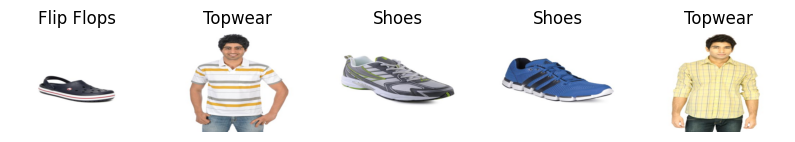

In [8]:

fig, ax = plt.subplots(1,5, figsize=(10,3))
for i in range(5):
    sample = dataset[100+i]
    ax[i].imshow(sample['image'])
    plt.axis='off'
    ax[i].set_title(sample['subCategory'])
    ax[i].axis('off')
plt.show()

We create train/val/test splits (80/10/10)

In [9]:
dataset_train_valid = dataset.select(range(0, len(dataset) * 9 // 10))
dataset_test = dataset.select(range(len(dataset) * 9 // 10, len(dataset)))

In [10]:
dataset_train_valid = dataset_train_valid.train_test_split(test_size=0.1)


Loading cached split indices for dataset at C:/Users/user/.cache/huggingface/datasets/ceyda___parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-6cda900b61e474cd.arrow and C:/Users/user/.cache/huggingface/datasets/ceyda___parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-d60fc65bfdc7a3d8.arrow


In [11]:
dataset_train_valid

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image', 'subCategory_cat'],
        num_rows: 4050
    })
    test: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image', 'subCategory_cat'],
        num_rows: 450
    })
})

In [12]:
dataset_test 

Dataset({
    features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image', 'subCategory_cat'],
    num_rows: 500
})

## Train a baseline

We define a very simple CNN model, using MobileNetV2 pretrained on Imagenet as backbone and then performing transfer learning on the target dataset

In [13]:


def get_cnn_classifier():
    backbone = MobileNetV2(include_top=False, pooling='max', input_shape=(128,128,3))
    backbone.trainable = False

    i = Input((128,128,3))
    x = backbone(i)
    x = Dropout(0.2)(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(dataset_df_full.subCategory.nunique(), activation='softmax')(x)
    return Model(i,x)

baseline_model = get_cnn_classifier()
baseline_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 45)                5805      
                                                                 
Total params: 2,427,757
Trainable params: 169,773
Non-trainable params: 2,257,984
_____________________________________________

We train the model using a standard Adam optimizer against the sparse categorical crossentropy, as customary in classification problems

In [14]:
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We use HuggingFace API to transform the datasets into tf.data.Dataset objects

In [15]:
ds_train = dataset_train_valid['train'].to_tf_dataset(columns=['image'], label_cols=['subCategory_cat'], batch_size=16, shuffle=True)
ds_val = dataset_train_valid['test'].to_tf_dataset(columns=['image'], label_cols=['subCategory_cat'], batch_size=16, shuffle=True)
ds_test = dataset_test.to_tf_dataset(columns=['image'], label_cols=['subCategory_cat'], batch_size=16)

In [16]:
def process_image(image, label):
    #image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, 128, 128)
    image = preprocess_input(image)
    return image, label

ds_train = ds_train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()
ds_val = ds_val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()
ds_test = ds_test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

In [17]:
#brief read test, check sample's max pixel
for x, y in ds_train.take(1):
    print(np.max(x))

1.0


In [18]:
for x, y in ds_test.take(3):
    print(y)

tf.Tensor([ 4 28  1  0  0  4  6  0  2  0 13  7  7  4  4  7], shape=(16,), dtype=int64)
tf.Tensor([ 7  2 12  2  1  4  0  4  4 18  0  7  0  0 11  4], shape=(16,), dtype=int64)
tf.Tensor([ 8  0  0  0 12  4  0  4  7  0  0  7  8  6  0  4], shape=(16,), dtype=int64)


We will train only for 10 epochs with EarlyStopping and LR reduction at plateau callbacks. To run longer training (on the full dataset), we would need to run the experiment on a GPU.

In [19]:

baseline_model.fit(ds_train, validation_data=ds_val, 
                   epochs=20, verbose=1, 
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=2)])
#baseline_model.save('../data/models/baseline_fashion/v1')

Epoch 1/20
254/254 [==============================] - 154s 548ms/step - loss: 0.8733 - accuracy: 0.7956 - val_loss: 0.6185 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 2/20
254/254 [==============================] - 90s 355ms/step - loss: 0.3525 - accuracy: 0.9032 - val_loss: 0.5953 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 3/20
254/254 [==============================] - 74s 290ms/step - loss: 0.2228 - accuracy: 0.9363 - val_loss: 0.5405 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 4/20
254/254 [==============================] - 78s 306ms/step - loss: 0.1564 - accuracy: 0.9469 - val_loss: 0.6207 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 5/20
254/254 [==============================] - 80s 317ms/step - loss: 0.1368 - accuracy: 0.9523 - val_loss: 0.5394 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 6/20
254/254 [==============================] - 78s 306ms/step - loss: 0.0968 - accuracy: 0.9672 - val_loss: 0.6545 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/20
254/254 [==============================]

In [20]:
#baseline_model = tf.keras.models.load_model('../data/models/baseline_fashion/v1')

In [21]:
loss, acc = baseline_model.evaluate(ds_test, verbose=1)
baseline_predictions = baseline_model.predict(ds_test)
print('Baseline model, accuracy: {}, loss: {}'.format(acc, loss))

32/32 [==============================] - 8s 244ms/step - loss: 0.4838 - accuracy: 0.8880
Baseline model, accuracy: 0.8880000114440918, loss: 0.48380833864212036


In [22]:
labels = [x.lower() for x in dataset_test['subCategory']]
baseline_predicted_labels = [dataset_test.features['subCategory_cat'].names[x].lower() for x in np.argmax(baseline_predictions, axis=1)]
baseline_predicted_scores = np.max(baseline_predictions, axis=1)

print(f"Accuracy: {accuracy_score(labels, baseline_predicted_labels)}, precision: {precision_score(labels, baseline_predicted_labels, average='weighted')}, recall: {recall_score(labels, baseline_predicted_labels, average='weighted')}")

Accuracy: 0.888, precision: 0.9055523593339831, recall: 0.888


c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We report an accuracy of about 87%, with a weighted 85% precision and 87% recall. 

## Zero-shot model

Now we set up the zero shot model. We grab the list of labels from the dataset and initialize the model, using the CLIP backend.

We attach the prefix "a photo of a " to each label. As stated in the CLIP paper, this helps the model to better capture the semantic meaning of the image.

In [23]:
unique_labels = dataset_df_full.subCategory.unique().tolist()
print("Unique labels: ", unique_labels)

query_prefix = 'a photo of a ' #. We add a prefix to each of the text labels. This trick can improve performance significantly, as referenced in the CLIP paper

zeroshot_unique_labels = [query_prefix + label.lower() for label in unique_labels] 
zeroshot_clip_model = ZeroShotImageClassificationHandler(CLIP_Model(), zeroshot_unique_labels)

Unique labels:  ['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts', 'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories', 'Fragrance', 'Jewellery', 'Saree', 'Eyewear', 'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets', 'Apparel Set', 'Headwear', 'Lips', 'Mufflers', 'Skin Care', 'Makeup', 'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Nails', 'Beauty Accessories', 'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves', 'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles', 'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands', 'Vouchers']


In [24]:
clip_predictions_dicts =  zeroshot_clip_model(dataset_test['image'], top_k=1) 

clip_predictions_classes = [list(pred.keys())[0].replace(query_prefix,'') for pred in clip_predictions_dicts] #remove the query prefix for better readability
clip_predictions_scores = [list(pred.values())[0] for pred in clip_predictions_dicts]

print(f"Accuracy: {accuracy_score(labels, clip_predictions_classes)}, precision: {precision_score(labels, clip_predictions_classes, average='weighted')}, recall: {recall_score(labels, clip_predictions_classes, average='weighted')}")

32it [01:31,  2.85s/it]                        

Request handled in 91.23656299999857 seconds
Accuracy: 0.668, precision: 0.84640272059459, recall: 0.668



c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We obtain a 66% accuracy, with a 84% precision, close to the one registered by the baseline. Analyzing some off-the-records tests, we noticed how the "bottomwear" label is misleading for the model, leading to some strange predictions. For this reason, we remap the "bottomwear" remapping to "pair of pants" and test the model on this setup. 

In [25]:
remap_targets_dict = {'a photo of a bottomwear': 'a photo of a pair of pants'}
zeroshot_unique_labels_v2 = [remap_targets_dict.get(x,x) for x in zeroshot_unique_labels]
zeroshot_clip_model_v2 = ZeroShotImageClassificationHandler(CLIP_Model(), zeroshot_unique_labels_v2)

clip_predictions_dicts_v2 =  zeroshot_clip_model_v2(dataset_test['image'], top_k=1) 

clip_predictions_classes_v2 = [list(pred.keys())[0].replace(query_prefix,'') for pred in clip_predictions_dicts_v2] #remove the query prefix for better readability
clip_predictions_scores_v2 = [list(pred.values())[0] for pred in clip_predictions_dicts_v2]

remap_inverse = {'pair of pants': 'bottomwear'}
clip_predictions_classes_v2 = [remap_inverse.get(x,x) for x in clip_predictions_classes_v2]

print(f"Accuracy: {accuracy_score(labels, clip_predictions_classes_v2)}, precision: {precision_score(labels, clip_predictions_classes_v2, average='weighted')}, recall: {recall_score(labels, clip_predictions_classes_v2, average='weighted')}")

32it [01:30,  2.82s/it]                        

Request handled in 90.1800699000014 seconds
Accuracy: 0.692, precision: 0.8688073512419546, recall: 0.692



c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\source\repos\Text2ImageAndBack\Text2ImageAndBack\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We record an improvement of 3 percent points in terms of accuracy, precision,recall. Notice how the precision now outperforms the baseline.

## Error analysis

To get a better insight on the predictions, we print out the confusion matrix for the baseline and the zero-shot model. We will refer to the second version of the zero shot model, the one with the remapped labels. From this analysis, data scientis might gain further insights to test different setups of the zero shot problem, leading to further performance improvements.

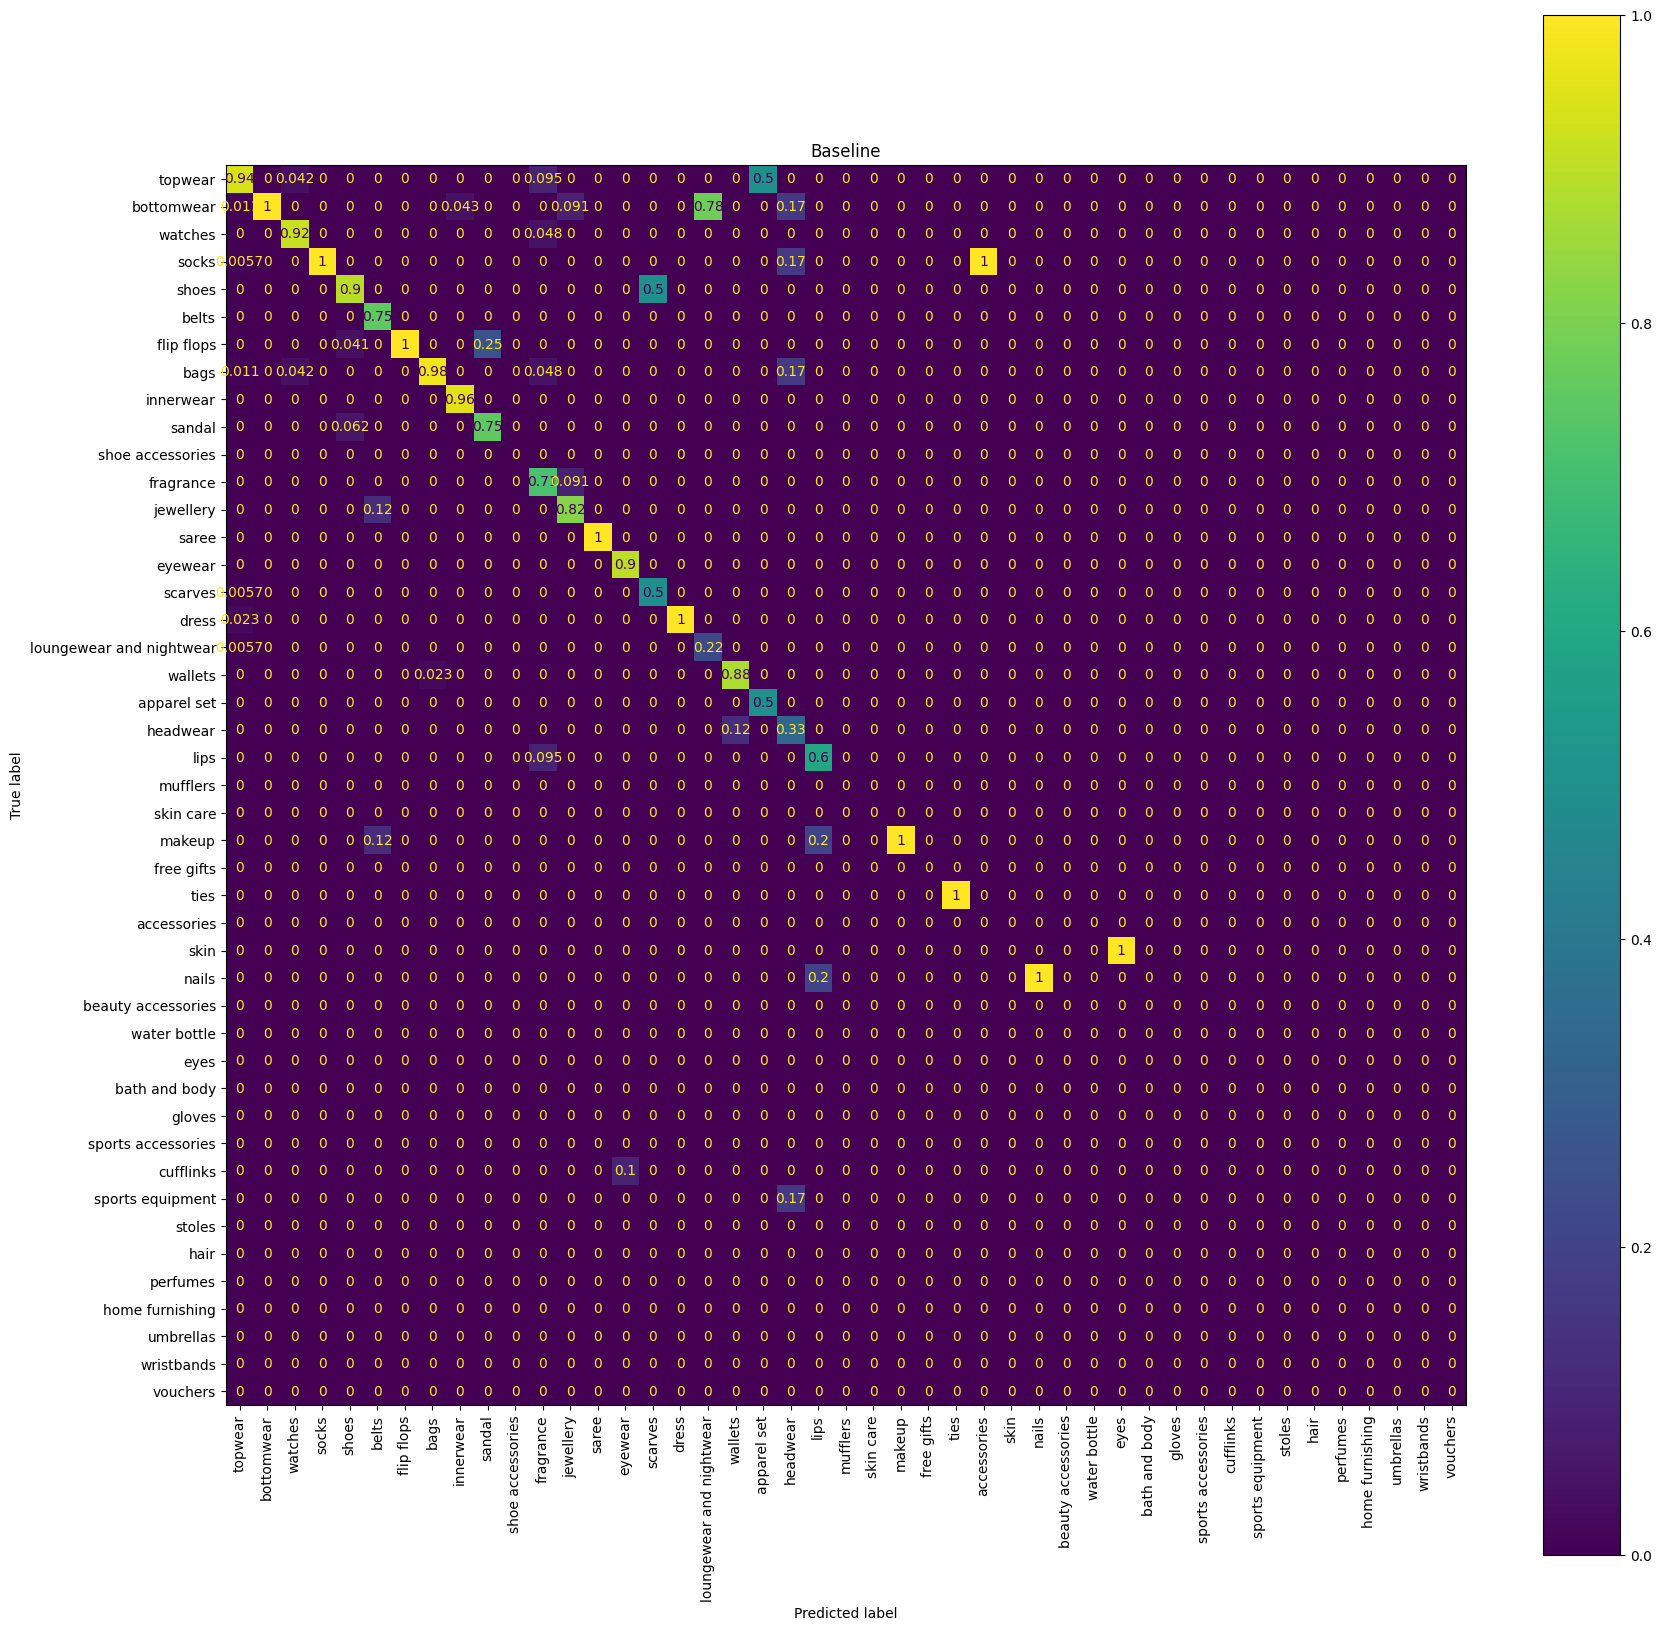

In [26]:
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(labels, baseline_predicted_labels, labels=[x.lower() for x in dataset_test.features['subCategory_cat'].names], normalize='pred', xticks_rotation='vertical')
plt.title('Baseline')
plt.show()

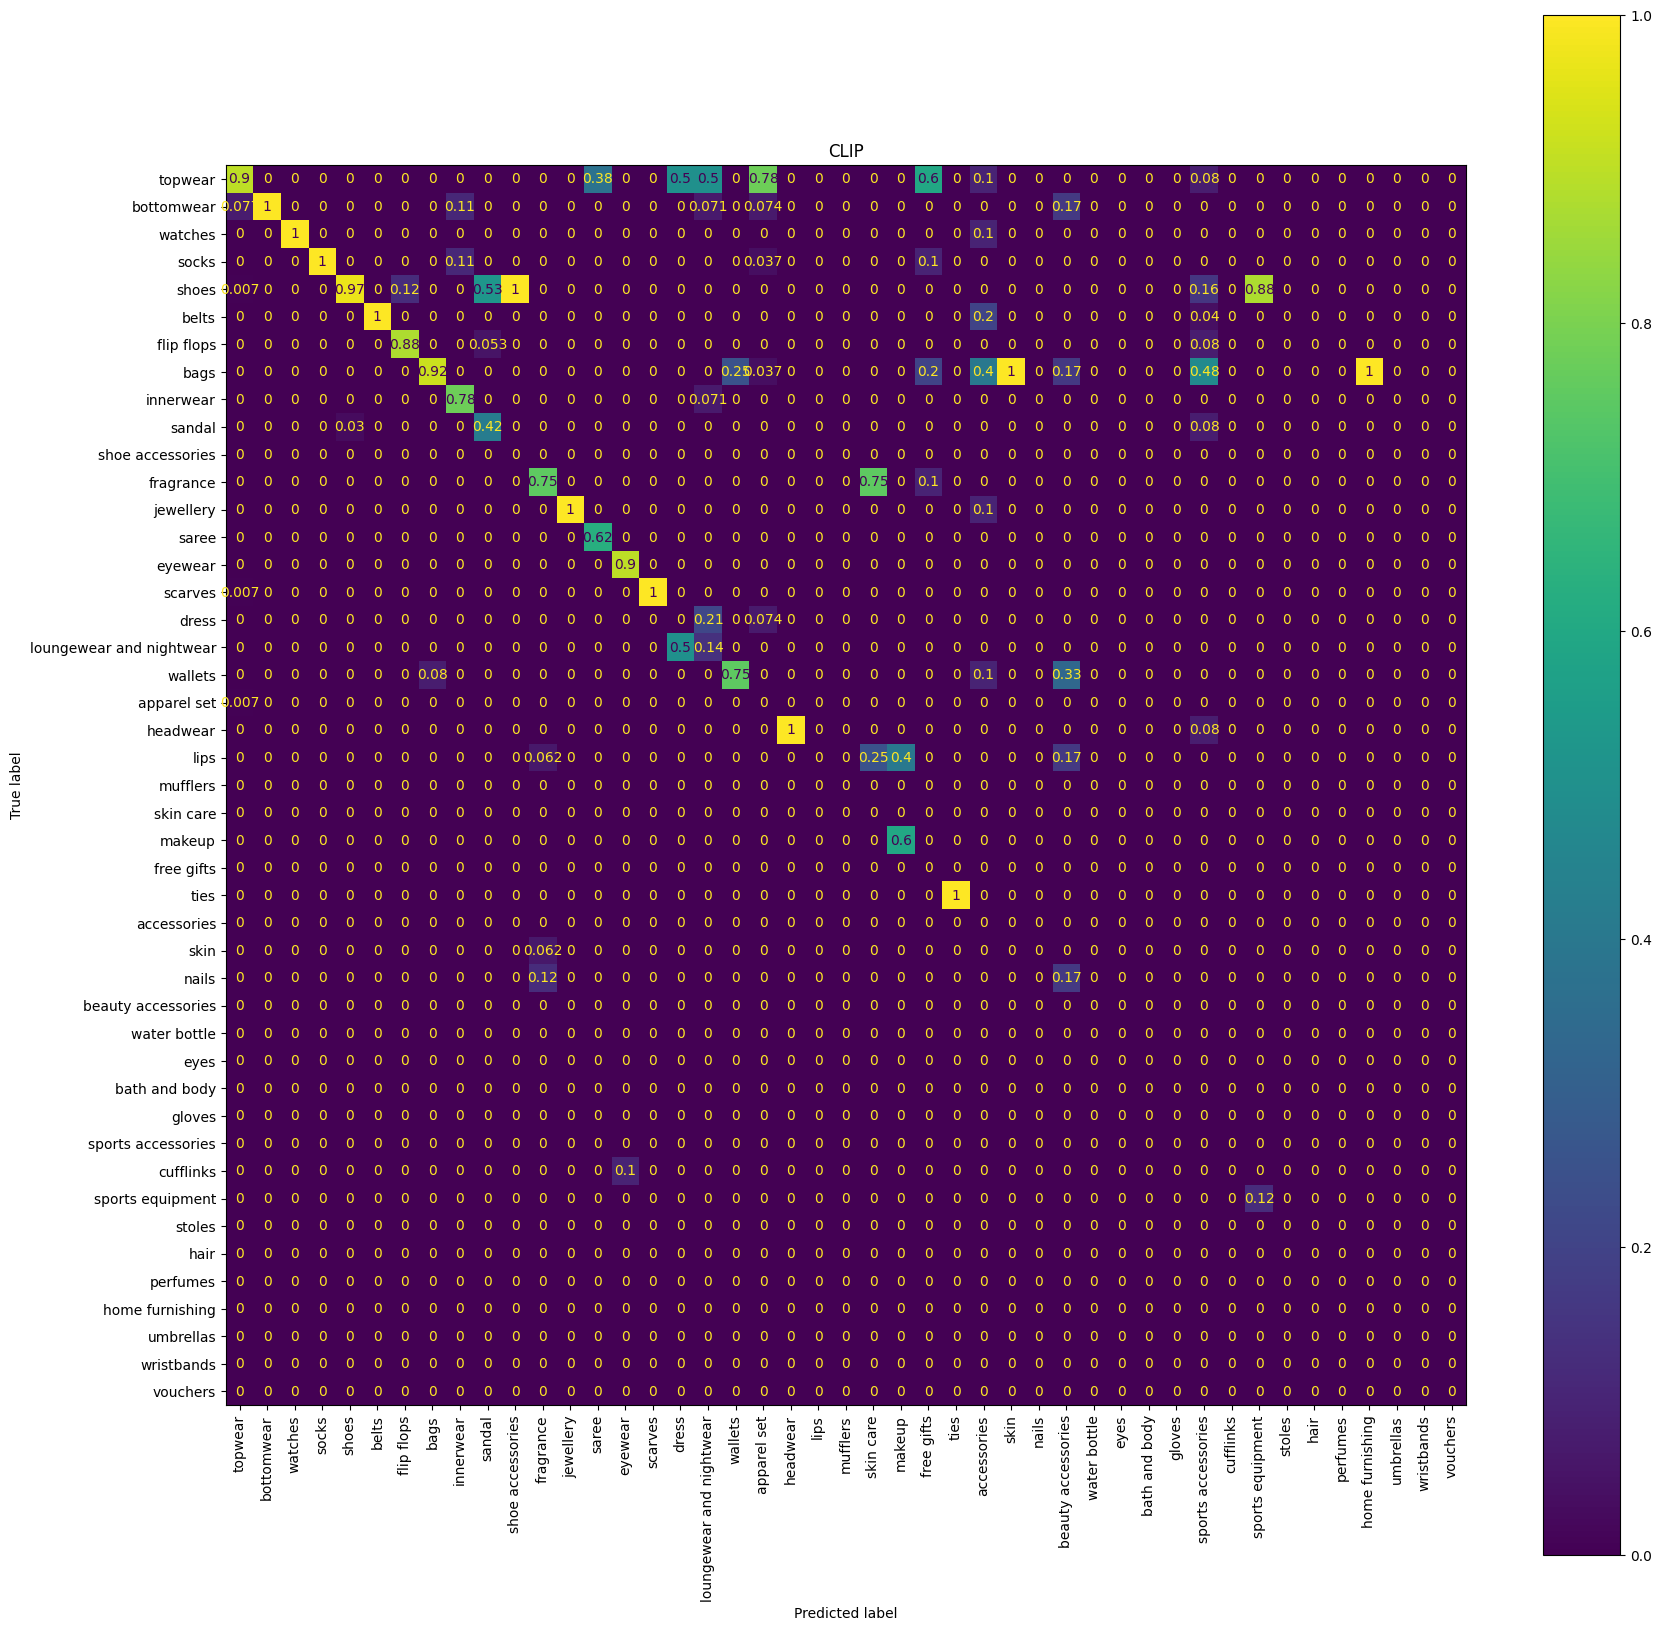

In [27]:
ConfusionMatrixDisplay.from_predictions(labels, clip_predictions_classes_v2, labels=[x.lower() for x in dataset_test.features['subCategory_cat'].names], normalize='pred', xticks_rotation='vertical')
plt.title('CLIP')
plt.show()

It is also useful to visualize errors, especially the one where the model records an high confidence.

BASELINE
Displaying 20 errors...


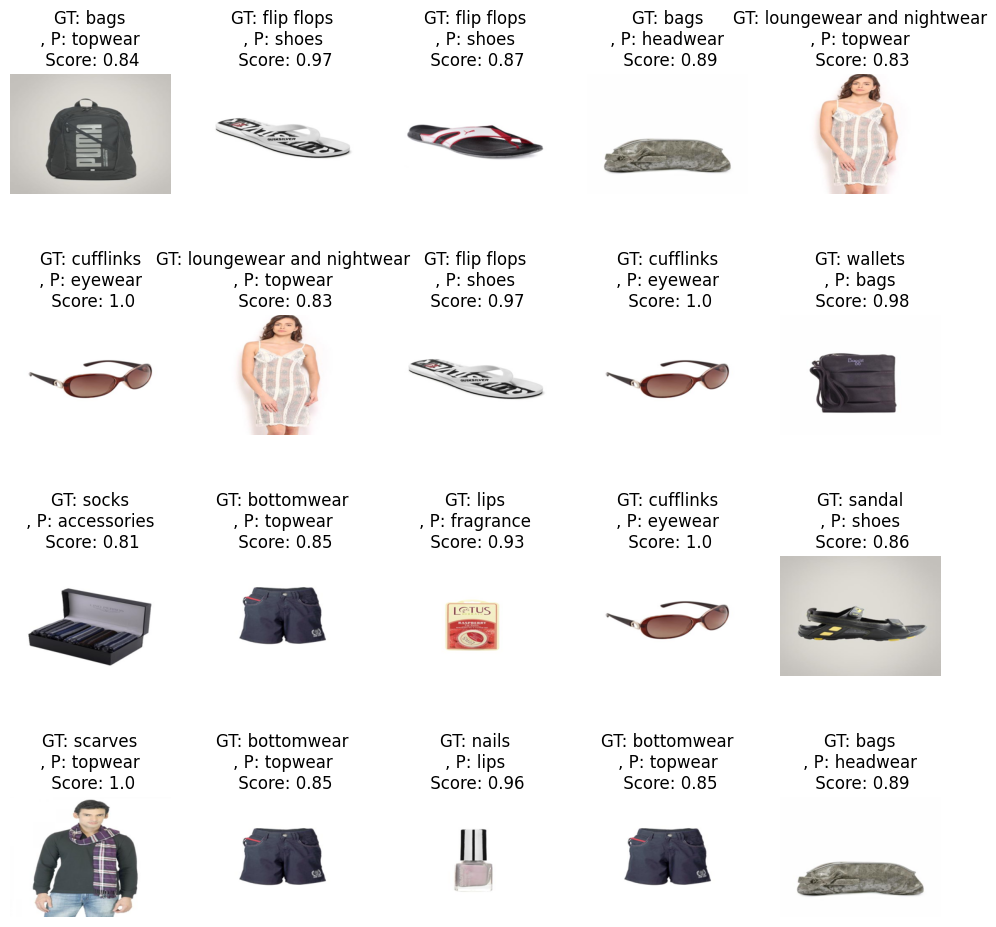

In [28]:
def display_errors(labels, predictions, scores, min_errors = 20, score_thr=0.8):
    error_idxs = [i for i, x in enumerate(zip(labels,predictions,scores)) if x[0]!=x[1] and x[2] > score_thr]
    error_idxs = random.choices(error_idxs, k=min(len(error_idxs), min_errors))
    print(f"Displaying {len(error_idxs)} errors...")
    dataset_test_errors = dataset_test.select(error_idxs)
    
    sqrt_errors = np.sqrt(len(error_idxs))
    n_rows = int(np.floor(sqrt_errors))
    n_cols = int(np.ceil(sqrt_errors))
    
    fig, ax = plt.subplots(n_rows,n_cols, figsize=(12,12))
    for i in range(n_rows):
        for j in range(n_cols):
            if i*n_cols + j >= len(error_idxs):
                continue
            linear_idx = error_idxs[i*n_cols + j]
            sample = dataset_test_errors[i*n_cols + j]
            ax[i,j].imshow(sample['image'])
            plt.axis='off'
            ax[i,j].set_title(f"GT: {labels[linear_idx]}\n, P: {predictions[linear_idx]}\n Score: {round(float(scores[linear_idx]),2)}")
            ax[i,j].axis('off')
    plt.show()

print("BASELINE")
display_errors(labels, baseline_predicted_labels, baseline_predicted_scores)


ZERO SHOT
Displaying 4 errors...


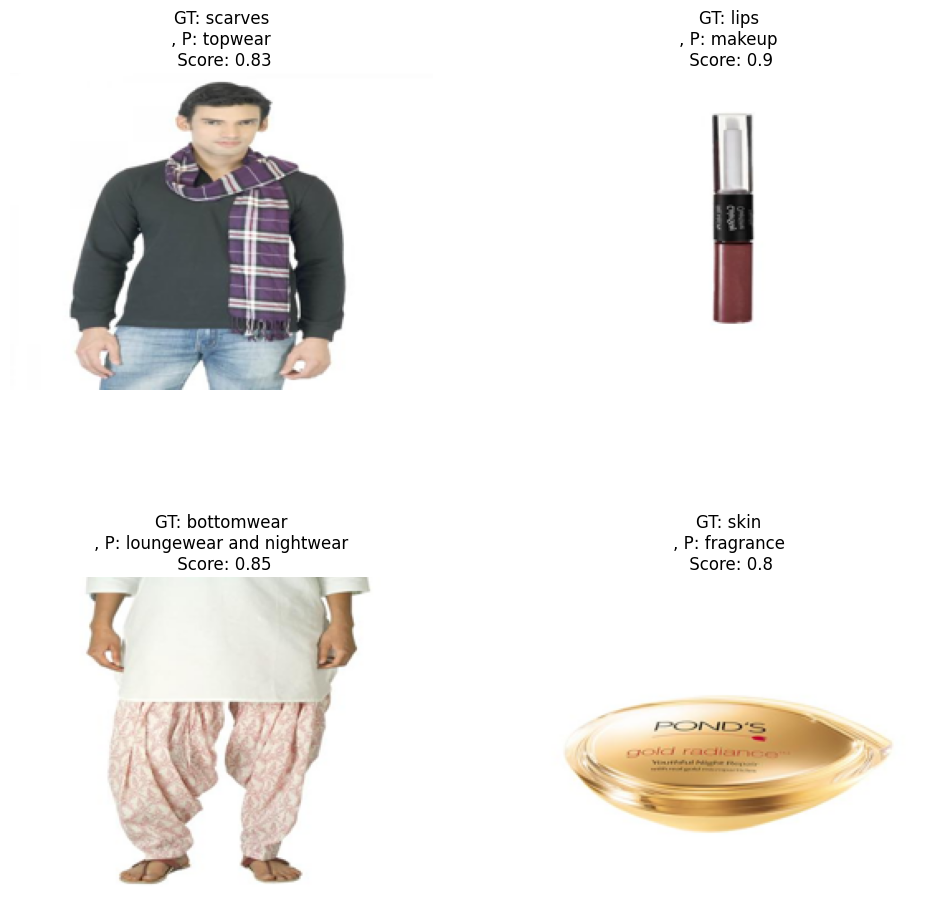

In [29]:
print("ZERO SHOT")
display_errors(labels, clip_predictions_classes_v2, clip_predictions_scores_v2)


The visualizer function is set to display a maximum of errors with confidence > 0.8. Nevertheless, we find only 4 "confident" errors for the zero shot models. All errors look plausible and human-like. The "scarves" sample is hard to distinguish from the predicted class "topwear" due to how the photo is taken. The "bottomwear" sample is duplicated and the prediction look suitable to the garment. The "lips/makeup" error might be fixed by a better target labels engineering (ex. rename "lips" to "lips care" or "lips makeup"). 

## Exploit zero-shot 

We try to build a training set with reliable zero-shot predictions. 

In [30]:
#clip_predictions_train = []
#for batch_idxs in batch(range(5000, len(full_dataset)), 128):
#    clip_predictions_train_batch = zeroshot_clip_model_v2(full_dataset.select(batch_idxs)['image'], top_k=1) #predictions_dict: 
#    clip_predictions_train.append(clip_predictions_train_batch)
    
zeroshot_dataset_addon_images = full_dataset.select(range(5000, 25000))
zeroshot_dataset = process_hf_dataset(zeroshot_dataset_addon_images)

clip_predictions_train = zeroshot_clip_model_v2(zeroshot_dataset['image'], top_k=1) #predictions_dict: 

Loading cached processed dataset at C:/Users/user/.cache/huggingface/datasets/ceyda___parquet/ceyda--fashion-products-small-ad468eb94e8d93de/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-d91e9a1022273587.arrow
100%|██████████| 1250/1250 [1:10:48<00:00,  3.40s/it]

Request handled in 4249.0661425 seconds


In [31]:
clip_predictions_labels_train = [list(pred.keys())[0].replace(query_prefix,'') for pred in clip_predictions_train] 
clip_predictions_labels_train = [remap_inverse.get(x,x) for x in clip_predictions_labels_train]
clip_predictions_scores_train = [list(pred.values())[0] for pred in clip_predictions_train] 

In [35]:
thr = 0.7

#Filter predictions by threshold
valid_idxs_train = [i for i, score in enumerate(clip_predictions_scores_train) if score > thr]
print(f"Selected {len(valid_idxs_train)} samples out of {len(clip_predictions_scores_train)}")

labels_mapping_order = [x.lower() for x in dataset_train_valid['train'].features['subCategory_cat'].names]
labels_train = []
for i in valid_idxs_train:
    labels_train += [labels_mapping_order.index(clip_predictions_labels_train[i])]

Selected 6248 samples out of 20000


In [72]:
#Create the new datasets
dataset_train_valid_zeroshot = zeroshot_dataset.select(valid_idxs_train)
#Adapt to TF
ds_train_zero = tf.data.Dataset.from_tensor_slices((dataset_train_valid_zeroshot['image'], labels_train))
#ds_train_zero = dataset_train_valid_zeroshot.to_tf_dataset(columns=['image'], label_cols=['subCategory_cat'], batch_size=16, shuffle=True)


In [73]:
def process_image(image, label):
    #image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, 128, 128)
    image = preprocess_input(image)
    return image, label

ds_train_zero_opt = ds_train_zero.batch(16).map(process_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

Now we retrain the same baseline model architecture using this dataset. We only change the number of neurons of the last layer, to match the number of labels seen in the training set.

In [80]:
baseline_model_withzero = get_cnn_classifier()
baseline_model_withzero.summary()
baseline_model_withzero.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               163968    
                                                                 
 dense_17 (Dense)            (None, 45)                5805      
                                                                 
Total params: 2,427,757
Trainable params: 169,773
Non-trainable params: 2,257,984
___________________________________________

In [81]:
baseline_model_withzero.fit(ds_train_zero_opt, validation_data=ds_val, 
                   epochs=20, verbose=1, 
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(patience=5)])


Epoch 1/20
391/391 [==============================] - 98s 244ms/step - loss: 1.3093 - accuracy: 0.7206 - val_loss: 1.4837 - val_accuracy: 0.7178 - lr: 1.0000e-04
Epoch 2/20
391/391 [==============================] - 93s 239ms/step - loss: 0.4249 - accuracy: 0.8956 - val_loss: 1.4892 - val_accuracy: 0.7311 - lr: 1.0000e-04
Epoch 3/20
391/391 [==============================] - 92s 234ms/step - loss: 0.2912 - accuracy: 0.9205 - val_loss: 1.5054 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 4/20
391/391 [==============================] - 90s 231ms/step - loss: 0.2121 - accuracy: 0.9365 - val_loss: 1.6213 - val_accuracy: 0.7178 - lr: 1.0000e-04
Epoch 5/20
391/391 [==============================] - 90s 231ms/step - loss: 0.1621 - accuracy: 0.9513 - val_loss: 1.6237 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 6/20
391/391 [==============================] - 90s 231ms/step - loss: 0.1306 - accuracy: 0.9614 - val_loss: 1.7138 - val_accuracy: 0.7311 - lr: 1.0000e-04
Epoch 7/20
391/391 [========

In [82]:
loss, acc = baseline_model_withzero.evaluate(ds_test, verbose=1)
supervised_fromzero_predictions = baseline_model_withzero.predict(ds_test)
print('Supervised from zero model, accuracy: {}, loss: {}'.format(acc, loss))

32/32 [==============================] - 7s 210ms/step - loss: 1.3090 - accuracy: 0.7040
Supervised from zero model, accuracy: 0.7039999961853027, loss: 1.3089640140533447


In [83]:
labels = [x.lower() for x in dataset_test['subCategory']]
supervisedfromzero_predicted_labels = [full_dataset.features['subCategory_cat'].names[x].lower() for x in np.argmax(supervised_fromzero_predictions, axis=1)]
supervisedfromzero_predicted_scores = np.max(supervised_fromzero_predictions, axis=1)

print(f"Accuracy: {accuracy_score(labels, supervisedfromzero_predicted_labels)}, precision: {precision_score(labels, supervisedfromzero_predicted_labels, average='weighted')}, recall: {recall_score(labels, supervisedfromzero_predicted_labels, average='weighted')}")

KeyError: 'subCategory_cat'